In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

First thing I want to do is to check if MPS is available since I am using Apple M2 Chip and would like to use the device GPU

In [9]:
def check_mps_available():
  if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
      print("MPS not available because PyTorch was not built with MPS enabled"
          )
    else:
      print("MPS not available because the current MacOS version is not 12.3+ and /or you do not have an MPS-enabled device")
      
    return False
  return True

def get_device():
  if check_mps_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
  else:
    device = torch.device('cpu')
    print("Using CPU")
  return device
  
device = get_device()

Using MPS (Apple Silicon GPU)


## SimpleNN
A simple neural network model for binary classification.

### Parameters:
- `input_size` (int, default=2): Number of input features
- `hidden_size` (int, default=5): Number of neurons in hidden layer
- `output_size` (int, default=1): Number of output neurons

### Architecture:
1. First Linear Layer: input_size → hidden_size
2. ReLU Activation
3. Second Linear Layer: hidden_size → output_size

### Usage Example:
```python
model = SimpleNN(input_size=2, hidden_size=5, output_size=1)

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=5, output_size=1):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

## Data Preparation

In [11]:
# Create synthetic data
np.random.seed(42)  # For reproducibility
X = np.random.randn(500, 2)    # 100 samples, 2 features each
y = (X[:,0] + X[:,1] > 0).astype(np.float32)  # Classification rule

# Convert to PyTorch tensors|
X_tensor = torch.FloatTensor(X).to(device)
y_tensor = torch.FloatTensor(y).view(-1,1).to(device)

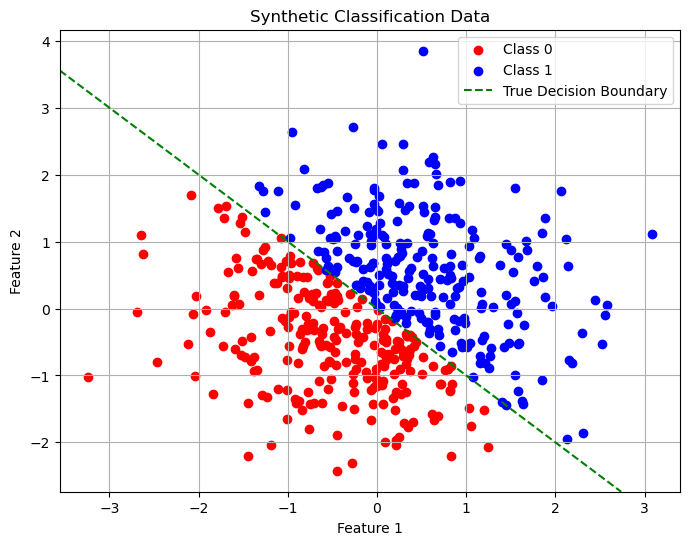

In [12]:


plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1')
plt.axline([0, 0], [1, -1], color='green', linestyle='--', label='True Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic Classification Data')
plt.legend()
plt.grid(True)
plt.show()

## Training Setup

In [ ]:
model = SimpleNN().to(device)

# Loss function: Measures prediction errors
criterion = nn.BCEWithLogitsLoss()

# Optimizer: Updates network weights
optimizer = optim.SGD(model.parameters(), lr=0.01)


## Training Loop

In [ ]:
losses = []
print("Training the Model ....")
for epoch in range(1000):
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/100], Loss: {loss.item():.4f}')

# After training, plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

## Model Evaluation

In [ ]:
# 1. First show the decision boundary with predictions
plt.figure(figsize=(8, 6))

# Plot the decision regions
plt.contourf(xx, yy, Z > 0.5, alpha=0.3, colors=['purple', 'yellow'])
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

# Plot correct and incorrect predictions
plt.scatter(X[correct_mask & (y == 0), 0], X[correct_mask & (y == 0), 1], 
           color='red', marker='o', label='Correct Class 0')
plt.scatter(X[correct_mask & (y == 1), 0], X[correct_mask & (y == 1), 1], 
           color='blue', marker='o', label='Correct Class 1')
plt.scatter(X[incorrect_mask & (y == 0), 0], X[incorrect_mask & (y == 0), 1], 
           color='red', marker='x', s=100, label='Incorrect Class 0')
plt.scatter(X[incorrect_mask & (y == 1), 0], X[incorrect_mask & (y == 1), 1], 
           color='blue', marker='x', s=100, label='Incorrect Class 1')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Neural Network Decision Boundary\nX marks show incorrect predictions')
plt.legend()
plt.grid(True)
plt.show()

# 2. Then show the confusion matrix with metrics
plt.figure(figsize=(8, 6))

# Calculate confusion matrix
conf_matrix = torch.zeros(2, 2)
for t, p in zip(y_tensor.cpu(), predicted.cpu()):
    conf_matrix[t.long(), p.long()] += 1

# Plot confusion matrix
im = plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add numbers to confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{conf_matrix[i, j]:.0f}\n{labels[i*2 + j]}', 
                ha='center', va='center')

plt.colorbar()

# Calculate and display metrics
accuracy = (predicted == y_tensor).float().mean()
tn, fp, fn, tp = conf_matrix.flatten()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

metrics_text = f'Model Performance Metrics:\n\n'
metrics_text += f'Accuracy: {accuracy.item():.2%}\n'
metrics_text += f'Precision: {precision:.2%}\n'
metrics_text += f'Recall: {recall:.2%}\n'
metrics_text += f'F1 Score: {f1:.2%}'

plt.figtext(0.95, 1.0, metrics_text, 
            fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.8),
            ha='left', 
            va='center')

plt.tight_layout()
plt.show()